In [ ]:
import glob
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

def create_model(base_model, classData):
    for layer in base_model.layers:
        layer.trainable = False
            
    top_model = base_model.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    
    output_layer = Dense(classData, activation='softmax')(top_model)

    model = Model(inputs=base_model.input, outputs=output_layer)

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])        
            
    return model


train_path = '/content/drive/MyDrive/PaddyDisease/Aug_UnderSampling_Dataset/train'
test_path  = '/content/drive/MyDrive/PaddyDisease/Aug_UnderSampling_Dataset/test'
IMG_SHAPE = (256, 256, 3)
batch_size = 32
classData = 10

base_model = EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
)

model = create_model(base_model, classData)
# model.summary()

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=(256,256),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(256,256),
    batch_size=batch_size
)

Found 3030 files belonging to 10 classes.
Using 2727 files for training.
Found 3030 files belonging to 10 classes.
Using 303 files for validation.


In [ ]:
#custom callback
#checkpoint = ModelCheckpoint("rcnnplatemodel.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
86/86 [==============================] - 469s 5s/step - loss: 1.6052 - accuracy: 0.5589 - val_loss: 0.7605 - val_accuracy: 0.7525
Epoch 2/10
86/86 [==============================] - 415s 5s/step - loss: 0.4069 - accuracy: 0.8728 - val_loss: 0.6859 - val_accuracy: 0.8086
Epoch 3/10
86/86 [==============================] - 408s 5s/step - loss: 0.1711 - accuracy: 0.9501 - val_loss: 0.5968 - val_accuracy: 0.8383
Epoch 4/10
86/86 [==============================] - 419s 5s/step - loss: 0.1015 - accuracy: 0.9762 - val_loss: 0.5406 - val_accuracy: 0.8548
Epoch 5/10
86/86 [==============================] - 419s 5s/step - loss: 0.0595 - accuracy: 0.9864 - val_loss: 0.6067 - val_accuracy: 0.8581
Epoch 6/10
86/86 [==============================] - 448s 5s/step - loss: 0.0395 - accuracy: 0.9912 - val_loss: 0.5399 - val_accuracy: 0.8614
Epoch 7/10
86/86 [==============================] - 412s 5s/step - loss: 0.0432 - accuracy: 0.9890 - val_loss: 0.6914 - val_accuracy: 0.8416
Epoch 8/10
86

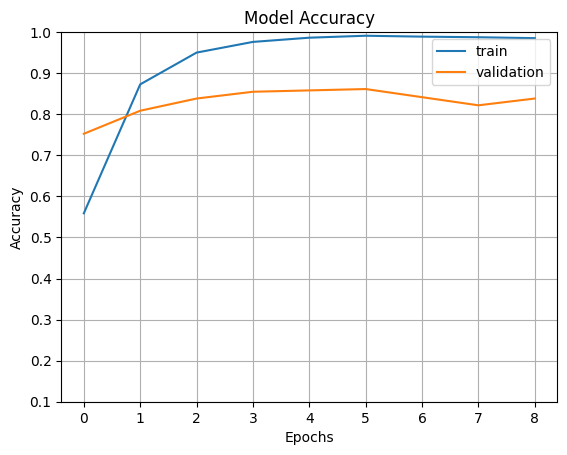

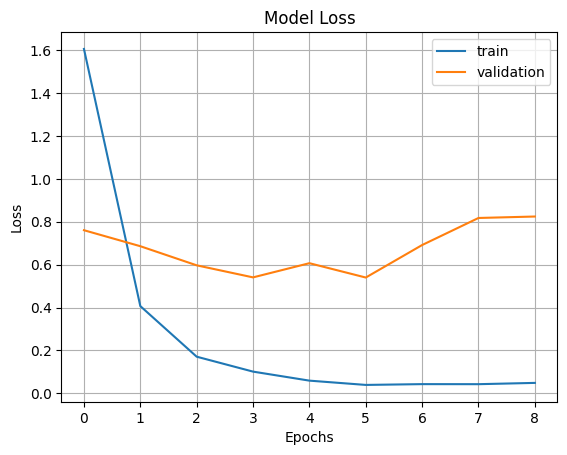

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=False,
    label_mode="categorical",
    image_size=(256,256),
    batch_size=1
)

predictions = model.predict(test_ds)

Found 340 files belonging to 10 classes.
340/340 [==============================] - 48s 136ms/step


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

class_names = ["bacterial_leaf_blight","bacterial_leaf_streak","bacterial_panicle_blight","blast","brown_spot","dead_heart","downy_mildew","hispa","normal","tungro"]

predicted_categories = np.argmax(predictions, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0).numpy()
true_categories_argmax = np.argmax(true_categories, axis=1)

print(classification_report(true_categories_argmax, predicted_categories, target_names=class_names))

                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.74      0.91      0.82        34
   bacterial_leaf_streak       0.89      0.94      0.91        34
bacterial_panicle_blight       0.76      1.00      0.86        34
                   blast       0.81      0.74      0.77        34
              brown_spot       0.91      0.59      0.71        34
              dead_heart       1.00      0.85      0.92        34
            downy_mildew       0.65      0.76      0.70        34
                   hispa       0.77      0.79      0.78        34
                  normal       0.87      0.76      0.81        34
                  tungro       0.90      0.79      0.84        34

                accuracy                           0.81       340
               macro avg       0.83      0.81      0.81       340
            weighted avg       0.83      0.81      0.81       340



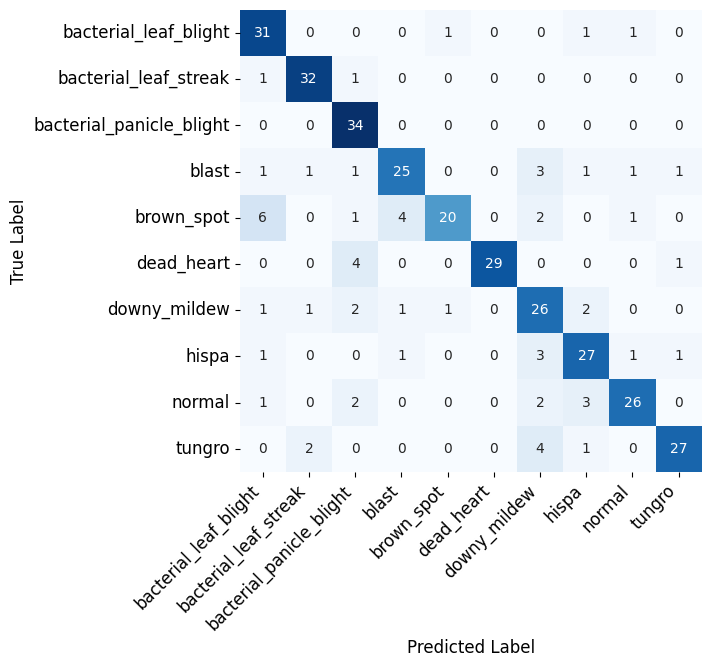

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class_names = ["bacterial_leaf_blight","bacterial_leaf_streak","bacterial_panicle_blight","blast","brown_spot","dead_heart","downy_mildew","hispa","normal","tungro"]

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_categories_argmax, predicted_categories, class_names, ax, title="EfficientNetV2B0-UnderSampling")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/PaddyDisease/EfficientNetV2B0/PaddyDisease_EfficientNetV2B0_UnderSampling.h5')